# Finite-Difference Playground: Using NRPy+-Generated C Codes in a Larger Project

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## Introduction: 
To illustrate how NRPy+-based codes can be used, we write a C code that makes use of the NRPy+-generated C code from the [previous module](Tutorial-Finite_Difference_Derivatives.ipynb). This is a rather silly example, as the C code generated by NRPy+ could be easily generated by hand. However, as we will see in later modules, NRPy+'s true strengths lie in its automatic handling of far more complex and generic expressions, in higher dimensions. For the time being, bear with NRPy+; its true powers will become clear soon!

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#outputc): Output the C file `finite_diff_tutorial-second_deriv.h`
1. [Step 2](#fdplayground): Finite-Difference Playground: A Complete C Code for Analyzing Finite-Difference Expressions Output by NRPy+
1. [Step 3](#exercise): Exercises to students
1. [Step 4](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='outputc'></a>

# Step 1: Output the C file `finite_diff_tutorial-second_deriv.h` \[Back to [top](#toc)\]
$$\label{outputc}$$

We start with the NRPy+ code from the [previous module](Tutorial-Finite_Difference_Derivatives.ipynb), and output it to the C file `finite_diff_tutorial-second_deriv.h`.

In [1]:
import sympy as sp
from outputC import *
import grid as gri
import indexedexp as ixp
import finite_difference as fin

# Set the spatial dimension to 1
par.set_paramsvals_value("grid::DIM = 1")

# Register the input gridfunction "phi" and the gridfunction to which data are output, "output":
phi, output = gri.register_gridfunctions("AUX",["phi","output"])

# Declare phi_dDD as a rank-2 indexed expression: phi_dDD[i][j] = \partial_i \partial_j phi
phi_dDD = ixp.declarerank2("phi_dDD","nosym")

# Set output to \partial_0^2 phi
output = phi_dDD[0][0]

# Output to the screen the core C code for evaluating the finite difference derivative
fin.FD_outputC("stdout",lhrh(lhs=gri.gfaccess("out_gf","output"),rhs=output))

# Now, output the above C code to a file named "finite_diff_tutorial-second_deriv.h".
fin.FD_outputC("finite_diff_tutorial-second_deriv.h",lhrh(lhs=gri.gfaccess("aux_gfs","output"),rhs=output))

{
   /* 
    * NRPy+ Finite Difference Code Generation, Step 1 of 2: Read from main memory and compute finite difference stencils:
    */
   /*
    *  Original SymPy expression:
    *  "const double phi_dDD00 = invdx0**2*(-5*phi/2 + 4*phi_i0m1/3 - phi_i0m2/12 + 4*phi_i0p1/3 - phi_i0p2/12)"
    */
   const double phi_i0m2 = aux_gfs[IDX2(PHIGF, i0-2)];
   const double phi_i0m1 = aux_gfs[IDX2(PHIGF, i0-1)];
   const double phi = aux_gfs[IDX2(PHIGF, i0)];
   const double phi_i0p1 = aux_gfs[IDX2(PHIGF, i0+1)];
   const double phi_i0p2 = aux_gfs[IDX2(PHIGF, i0+2)];
   const double phi_dDD00 = pow(invdx0, 2)*(-5.0/2.0*phi + (4.0/3.0)*phi_i0m1 - 1.0/12.0*phi_i0m2 + (4.0/3.0)*phi_i0p1 - 1.0/12.0*phi_i0p2);
   /* 
    * NRPy+ Finite Difference Code Generation, Step 2 of 2: Evaluate SymPy expressions and write to main memory:
    */
   /*
    *  Original SymPy expression:
    *  "aux_gfs[IDX2(OUTPUTGF, i0)] = phi_dDD00"
    */
   aux_gfs[IDX2(OUTPUTGF, i0)] = phi_dDD00;
}

Wrote to file "finite_d

<a id='fdplayground'></a>

# Step 2: Finite-Difference Playground: A Complete C Code for Analyzing Finite-Difference Expressions Output by NRPy+ \[Back to [top](#toc)\]
$$\label{fdplayground}$$

NRPy+ is designed to generate C code "kernels" at the heart of more advanced projects. As an example of its utility, let's now write a simple C code that imports the above file `finite_diff_tutorial-second_deriv.h` to evaluate the finite-difference second derivative of

$$f(x) = \sin(x)$$

at fourth-order accuracy. Let's call the finite-difference second derivative of $f$ evaluated at a point $x$ $f''(x)_{\rm FD}$. A fourth-order-accurate $f''(x)_{\rm FD}$ will, in the truncation-error-dominated regime, satisfy the equation

$$f''(x)_{\rm FD} = f''(x)_{\rm exact} + \mathcal{O}(\Delta x^4).$$

Therefore, the [relative error](https://en.wikipedia.org/wiki/Approximation_error) between the finite-difference derivative and the exact value should be given to good approximation by

$$E_{\rm Rel} = \left| \frac{f''(x)_{\rm FD} - f''(x)_{\rm exact}}{f''(x)_{\rm exact}}\right| \propto \Delta x^4,$$

so that (taking the logarithm of both sides of the equation):

$$\log_{10} E_{\rm Rel} = 4 \log_{10} (\Delta x) + \log_{10} (k),$$

where $k$ is the proportionality constant, divided by $f''(x)_{\rm exact}$.

Let's confirm this is true using our finite-difference playground code, which imports the NRPy+-generated C code generated above for evaluating $f''(x)_{\rm FD}$ at fourth-order accuracy, and outputs $\log_{10} (\Delta x)$ and $\log_{10} E_{\rm Rel}$ in a range of $\Delta x$ that is truncation-error dominated.

In [2]:
%%writefile finite_difference_playground.c

// Part P1: Import needed header files
#include "stdio.h"  // Provides printf()
#include "stdlib.h" // Provides malloc() and free()
#include "math.h"   // Provides sin()

// Part P2: Declare the IDX2(gf,i) macro, which enables us to store 2-dimensions of
//          data in a 1D array. In this case, consecutive values of "i" 
//          ("gf" held to a fixed value) are consecutive in memory, where 
//          consecutive values of "gf" (fixing "i") are separated by N elements in
//          memory.
#define IDX2(gf, i) ( (i) + Npts_in_stencil * (gf) )

// Part P3: Set PHIGF and OUTPUTGF macros
#define PHIGF    0
#define OUTPUTGF 1

// Part P4: Import code generated by NRPy+ to compute f''(x)
//          as a finite difference derivative.
void f_dDD_FD(double *in_gfs,double *aux_gfs,const int i0,const int Npts_in_stencil,const double invdx0)  {
#include "finite_diff_tutorial-second_deriv.h"
}

// Part P5: Define the function we wish to differentiate, as well as its exact second derivative:
double f(const double x)           { return  sin(x); } // f(x)
double f_dDD_exact(const double x) { return -sin(x); } // f''(x)

// Part P6: Define x_i = (x_0 + i*Delta_x)
double x_i(const double x_0,const int i,const double Delta_x) { 
    return (x_0 + (double)i*Delta_x);
}


// main() function
int main(int argc,char *argv[]) {
    // Step 0: Read command-line arguments (TODO)    
    
    // Step 1: Set some needed constants
    const int Npts_in_stencil = 5; // Equal to the finite difference order, plus one.  '+str(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER"))+'+1;
    const double PI = 3.14159265358979323846264338327950288; // The scale over which the sine function varies.
    const double x_eval = PI/4.0; // x_0 = desired x at which we wish to compute f(x)

    // Step 2: Evaluate f''(x_eval) using the exact expression:
    double EX = f_dDD_exact(x_eval);

    // Step 3: Allocate space for two gridfunctions
    double *in_gfs = (double *)malloc(sizeof(double)*Npts_in_stencil*2);

    // Step 4: Loop over grid spacings
    for(double Delta_x = 1e-3*(2*PI);Delta_x<=1.5e-1*(2*PI);Delta_x*=1.1) {

        // Step 4a: x_eval is the center point of the finite differencing stencil,
        //          thus x_0 = x_eval - 2*dx for fourth-order-accurate first & second finite difference derivs,
        //          and  x_0 = x_eval - 3*dx for sixth-order-accurate first & second finite difference derivs, etc.
        //          In general, for the integer Npts_in_stencil, we have
        //          x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x,
        //          where we rely upon integer arithmetic (which always rounds down) to ensure 
        //          Npts_in_stencil/2 = 5/2 = 2 for fourth-order-accurate first & second finite difference derivs:
        const double x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x;

        // Step 4b: Set \phi=PHIGF to be f(x) as defined in the 
        //          f(const double x) function above, where x_i = stencil_start_x + i*Delta_x:
        for(int ii=0;ii<Npts_in_stencil;ii++) {
            in_gfs[IDX2(PHIGF, ii)] = f(x_i(x_0,ii,Delta_x));
        }
        
        // Step 4c: Set invdx0, which is needed by the NRPy+-generated "finite_diff_tutorial-second_deriv.h"
        const double invdx0 = 1.0/Delta_x;

        // Step 4d: Evaluate the finite-difference second derivative of f(x):
        const int i0 = Npts_in_stencil/2; // The derivative is evaluated at the center of the stencil.
        f_dDD_FD(in_gfs,in_gfs,i0,Npts_in_stencil,invdx0);
        double FD = in_gfs[IDX2(OUTPUTGF,i0)];

        // Step 4e: Print log_10(\Delta x) and log_10([relative error])
        printf("%e\t%.15e\n",log10(Delta_x),log10(fabs((EX-FD)/(EX))));
    }
    
    // Step 5: Free the allocated memory for the gridfunctions.
    free(in_gfs);

    return 0;
}

Overwriting finite_difference_playground.c


Next we compile and run the C code.

In [3]:
import cmdline_helper as cmd
cmd.C_compile("finite_difference_playground.c", "fdp")
cmd.delete_existing_files("data.txt")
cmd.Execute("fdp", "", "data.txt")

Compiling executable...
Executing `gcc -Ofast -fopenmp -march=native finite_difference_playground.c -o fdp -lm`...
Finished executing in 0.224711179733 seconds.
Finished compilation.
Executing `taskset -c 0,1 ./fdp `...
Finished executing in 0.221477985382 seconds.


Finally, let's plot $\log_{10} E_{\rm Rel}$ as a function of $\log_{10} (\Delta x)$. Again, the expression at fourth-order accuracy should obey

$$\log_{10} E_{\rm Rel} = 4 \log_{10} (\Delta x) + \log_{10} (k).$$

Defining $\hat{x} = \log_{10} (\Delta x)$ and $y(\hat{x})=\log_{10} E_{\rm Rel}$, we can write the above equation in the more suggestive form:

$$y(\hat{x}) = 4 \hat{x} + \log_{10} (k),$$

so $y(\hat{x}) = \log_{10} E_{\rm Rel}\left(\log_{10} (\Delta x)\right)$ should be a line with positive slope of 4.

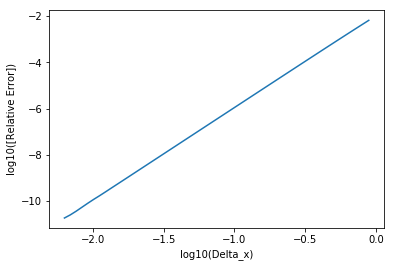

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# from https://stackoverflow.com/questions/12311767/how-to-plot-files-with-numpy
plt.plotfile('data.txt', delimiter = '\t', cols=(0,1), names=('log10(Delta_x)','log10([Relative Error])'))

A quick glance at the above plot indicates that between $\log_{10}(\Delta x) \approx -2.0$ and $\log_{10}(\Delta x) \approx -1.0$, the logarithmic relative error $\log_{10} E_{\rm Rel}$ increases by about 4, indicating a positive slope of approximately 4. Thus we have confirmed fourth-order convergence.

<a id='exercise'></a>

# Step 3: Exercises to students \[Back to [top](#toc)\]
$$\label{exercise}$$

1. Use NumPy's [`polyfit()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)  function to evaluate the least-squares slope of the above line.
2. Explore $\log_{10}(\Delta x)$ outside the above (truncation-error-dominated) range. What other errors dominate outside the truncation-error-dominated regime?
3. Adjust the above NRPy+ and C codes to support 6th-order-accurate finite differencing. What should the slope of the resulting plot of $\log_{10} E_{\rm Rel}$ versus $\log_{10}(\Delta x)$ be? Explain why this case does not provide as clean a slope as the 4th-order case.

<a id='latex_pdf_output'></a>

# Step 4: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-Finite_Difference_Playground.pdf](Tutorial-Start_to_Finish-Finite_Difference_Playground.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [5]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-Finite_Difference_Playground.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-Finite_Difference_Playground.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-Finite_Difference_Playground.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb to latex
[NbConvertApp] Support files will be in Tutorial-Start_to_Finish-Finite_Difference_Playground_files/
[NbConvertApp] Making directory Tutorial-Start_to_Finish-Finite_Difference_Playground_files
[NbConvertApp] Writing 36212 bytes to Tutorial-Start_to_Finish-Finite_Difference_Playground.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
